In [1]:
#Group:GLHF
#Team member
#1 Qianyue Zhang z5436473
#2 Zhewen Zhu z5369319
#3 Tinghao Li z5468081
#4 Yang He z5458975
#5 Hanbing Li z5497007

In [3]:
#In the submission, we submit the csv file together, which is used to load the data. And also we submit the
#one of the model(SegformerB0), and the other one（DeeplabV3) because it's over the file size limitation, so we don't submit
#it together. If you need it for further details, you can email us and we will provided it.

In [8]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights
import matplotlib.pyplot as plt
from tqdm import tqdm

In [9]:
#check the current file path
import os
# define the file path
folder_path = './dataset'

if os.path.exists(folder_path):
    print("Directory exists. Listing files:")

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            print("File:", filename)
        elif os.path.isdir(file_path):
            print("Directory:", filename)
else:
    print("Directory does not exist.")

Directory exists. Listing files:
Directory: K-01
Directory: K-03
Directory: V-01
Directory: V-02
Directory: V-03


In [10]:
import os
import random
import shutil
import glob

# Folders to be processed
folders = ['V-01', 'V-02', 'V-03','K-01','K-03']
# Base directory containing the dataset
base_dir = './dataset/'
# Directories to save sampled images and annotations
sampled_image_dir = './sample/images'
sampled_annotation_dir = './sample/labels'

# Create new folders to save the sampled files
os.makedirs(sampled_image_dir, exist_ok=True)
os.makedirs(sampled_annotation_dir, exist_ok=True)
print("Sample file folder has been created!")

# Iterate over each folder
for folder in folders:
    # Define image and annotation directories
    image_dir = os.path.join(base_dir, folder, 'image')
    annotation_dir = os.path.join(base_dir, folder, 'label')

    # Get lists of image and annotation files
    image_files = sorted(glob.glob(os.path.join(image_dir, '*.png')))
    annotation_files = sorted(glob.glob(os.path.join(annotation_dir, '*.png')))

    # Ensure the number of image and annotation files match
    assert len(image_files) == len(annotation_files), f"{folder} - Number of images and annotations do not match"

    # Randomly sample 10% of the data
    total_files = len(image_files)
    sample_size = int(total_files * 1)  # Sampling 10%

    # Get sample indices
    sample_indices = random.sample(range(total_files), sample_size)

    # Get sampled image and annotation files based on sample indices
    sampled_image_files = [image_files[i] for i in sample_indices]
    sampled_annotation_files = [annotation_files[i] for i in sample_indices]

    # Copy sampled files to new directories
    for img_file, ann_file in zip(sampled_image_files, sampled_annotation_files):
        shutil.copy(img_file, sampled_image_dir)
        shutil.copy(ann_file, sampled_annotation_dir)

print("Done")
print(len(image_files))

Sample file folder has been created!
Done
3913


In [11]:
import os
import pandas as pd
import glob

# Define paths for images and labels
image_dir = './sample/images'
label_dir = './sample/labels'

# Get all image and label files
image_files = sorted(glob.glob(os.path.join(image_dir, '*.png')))
label_files = sorted(glob.glob(os.path.join(label_dir, '*.png')))

# Ensure the lists of image and label files match
assert len(image_files) == len(label_files), "The number of image and label files do not match"

# Create a DataFrame to store paths
data = {
    'id': [os.path.splitext(os.path.basename(img))[0] for img in image_files],  # Extract file ID without extension
    'im_path': image_files,  # Paths to image files
    'label_path': label_files  # Paths to label files
}
df = pd.DataFrame(data)

# Save the DataFrame as a CSV file
csv_path = './paths.csv'
df.to_csv(csv_path, index=False)

print(f"CSV file has been saved to {csv_path}")

CSV file has been saved to ./paths.csv


In [12]:
#lable all the images in the sample folder.
import os
import numpy as np
import pandas as pd
from PIL import Image

# Define METAINFO dictionary
METAINFO = {
    "classes": (
        "unlabelled",
        "asphalt",
        "dirt",
        "mud",
        "water",
        "gravel",
        "other-terrain",
        "tree-trunk",
        "tree-foliage",
        "bush",
        "fence",
        "structure",
        "pole",
        "vehicle",
        "rock",
        "log",
        "other-object",
        "sky",
        "grass",
    ),
    "palette": [
        (0, 0, 0),
        (230, 25, 75),
        (60, 180, 75),
        (255, 225, 25),
        (0, 130, 200),
        (145, 30, 180),
        (70, 240, 240),
        (240, 50, 230),
        (210, 245, 60),
        (230, 25, 75),
        (0, 128, 128),
        (170, 110, 40),
        (255, 250, 200),
        (128, 0, 0),
        (170, 255, 195),
        (128, 128, 0),
        (250, 190, 190),
        (0, 0, 128),
        (128, 128, 128),
    ],
    "cidx": list(range(19))
}

# Create mapping dictionaries
palette = METAINFO['palette']
class_2_rgb = dict(zip(METAINFO['classes'], palette))
rgb_2_class = {tuple(color): cls for cls, color in class_2_rgb.items()}

# Function to read label image and extract labels
def extract_labels_from_image(image_path):
    img = Image.open(image_path)
    img = img.convert('RGB')
    np_img = np.array(img)
    unique_colors = np.unique(np_img.reshape(-1, 3), axis=0)

    labels = set()
    for color in unique_colors:
        color_tuple = tuple(color)
        if color_tuple in rgb_2_class:
            labels.add(rgb_2_class[color_tuple])

    return list(labels)

# Read original CSV data
csv_path = './paths.csv'
df = pd.read_csv(csv_path)

# Ensure the CSV contains the 'id' column
if 'id' not in df.columns:
    raise ValueError("The CSV file must contain the 'id' column")

# Add labels column to CSV
labels_list = []
for idx, row in df.iterrows():
    image_id = row['id']
    labels = extract_labels_from_image(os.path.join('./sample/labels', image_id + '.png'))
    labels_list.append(labels)
    
    if (idx + 1) % 100 == 0:
        print(f"Processed {idx + 1} images")

df['labels'] = labels_list

# Save the updated CSV file
df.to_csv('./paths_with_labels.csv', index=False)

print("CSV file has been updated!")

Processed 100 images
Processed 200 images
Processed 300 images
Processed 400 images
Processed 500 images
Processed 600 images
Processed 700 images
Processed 800 images
Processed 900 images
Processed 1000 images
Processed 1100 images
Processed 1200 images
Processed 1300 images
Processed 1400 images
Processed 1500 images
Processed 1600 images
Processed 1700 images
Processed 1800 images
Processed 1900 images
Processed 2000 images
Processed 2100 images
Processed 2200 images
Processed 2300 images
Processed 2400 images
Processed 2500 images
Processed 2600 images
Processed 2700 images
Processed 2800 images
Processed 2900 images
Processed 3000 images
Processed 3100 images
Processed 3200 images
Processed 3300 images
Processed 3400 images
Processed 3500 images
Processed 3600 images
Processed 3700 images
Processed 3800 images
Processed 3900 images
Processed 4000 images
Processed 4100 images
Processed 4200 images
Processed 4300 images
Processed 4400 images
Processed 4500 images
Processed 4600 imag

In [13]:
#check the labels in the samples
import pandas as pd
# Load the uploaded CSV file
file_path = './paths_with_labels.csv'
data = pd.read_csv(file_path)

# Extract all the unique labels from the 'labels' column
unique_labels = set()
for label_list in data['labels']:
    # Clean and split the label strings
    labels = label_list.strip("[]").replace("'", "").split(", ")
    # Update the set of unique labels
    unique_labels.update(labels)

# List of all possible classes
classes = [
    "unlabelled",
    "asphalt",
    "dirt",
    "mud",
    "water",
    "gravel",
    "other-terrain",
    "tree-trunk",
    "tree-foliage",
    "bush",
    "fence",
    "structure",
    "pole",
    "vehicle",
    "rock",
    "log",
    "other-object",
    "sky",
    "grass",
]

# Find the missing labels by checking which classes are not in unique_labels
missing_labels = [label for label in classes if label not in unique_labels]

# Print missing labels
print("Missing labels:", missing_labels)

Missing labels: ['unlabelled', 'asphalt']


In [14]:
#select 50% from the dataset.
import pandas as pd
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# Define the list of classes
classes = [
    "unlabelled",
    "asphalt",
    "dirt",
    "mud",
    "water",
    "gravel",
    "other-terrain",
    "tree-trunk",
    "tree-foliage",
    "bush",
    "fence",
    "structure",
    "pole",
    "vehicle",
    "rock",
    "log",
    "other-object",
    "sky",
    "grass",
]

# Read the CSV file
file_path = './paths_with_labels.csv'
data = pd.read_csv(file_path)

# Clean the labels data
data['labels'] = data['labels'].apply(lambda x: [label.strip().strip("'") for label in x.strip("[]").split(',')])

# Convert the labels to a binary matrix
mlb = MultiLabelBinarizer(classes=classes)
y = mlb.fit_transform(data['labels'])

# Extract feature columns
X = data[['id', 'im_path', 'label_path']].values  # Assuming 'id', 'im_path', 'label_path' are column names

# Use iterative_train_test_split to sample 50% of the data
X_remaining, y_remaining, X_sampled, y_sampled = iterative_train_test_split(X, y, test_size=0.5)

# Convert the binary matrix back to label lists
sampled_labels = mlb.inverse_transform(y_sampled)

# Convert the sampled data to a DataFrame
sampled_data = pd.DataFrame(data=X_sampled, columns=['id', 'im_path', 'label_path'])
sampled_data['labels'] = sampled_labels

# Save the sampled data to a CSV file
sampled_data.to_csv('./sampled_data.csv', index=False)

print("50% of the data has been sampled and saved to sampled_data.csv")
print(f"Sampled dataset size: {len(sampled_data)}")

50% of the data has been sampled and saved to sampled_data.csv
Sampled dataset size: 4653


In [15]:
#plot the label distribution
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast

def plot_label_counts(csv_file, classes):
    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Initialize a counter for labels
    label_counter = Counter()

    # Iterate through the dataframe and count labels
    for labels in df['labels']:
        # Convert the string representation of the list to an actual list
        label_list = ast.literal_eval(labels)
        label_counter.update(label_list)

    # Create a list of counts in the order of the provided classes
    label_counts = [label_counter[class_name] for class_name in classes]

    # Plot the label counts
    plt.figure(figsize=(12, 8))
    plt.bar(classes, label_counts)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Label Counts')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Define the list of classes in the desired order
classes = [
    "unlabelled",
    "asphalt",
    "dirt",
    "mud",
    "water",
    "gravel",
    "other-terrain",
    "tree-trunk",
    "tree-foliage",
    "bush",
    "fence",
    "structure",
    "pole",
    "vehicle",
    "rock",
    "log",
    "other-object",
    "sky",
    "grass",
]



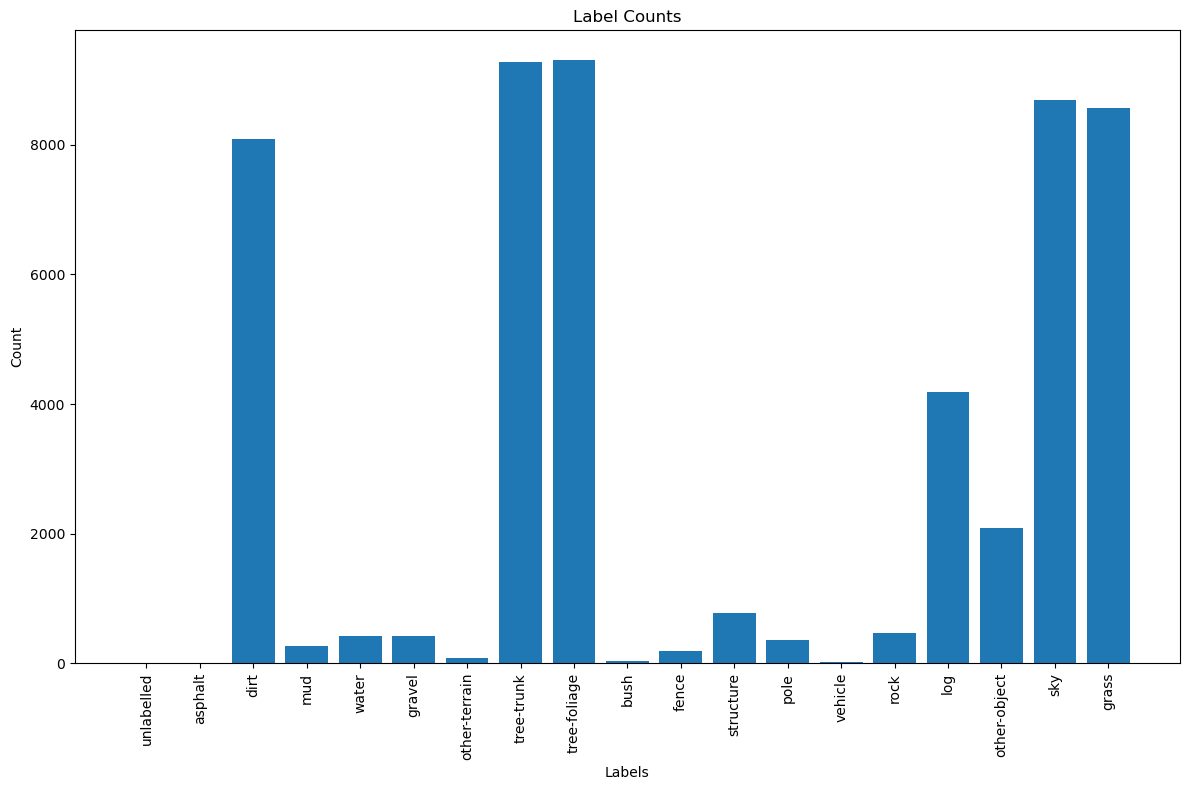

In [16]:
# Call the function with the path to the CSV file and the list of classes
plot_label_counts('./paths_with_labels.csv',classes)

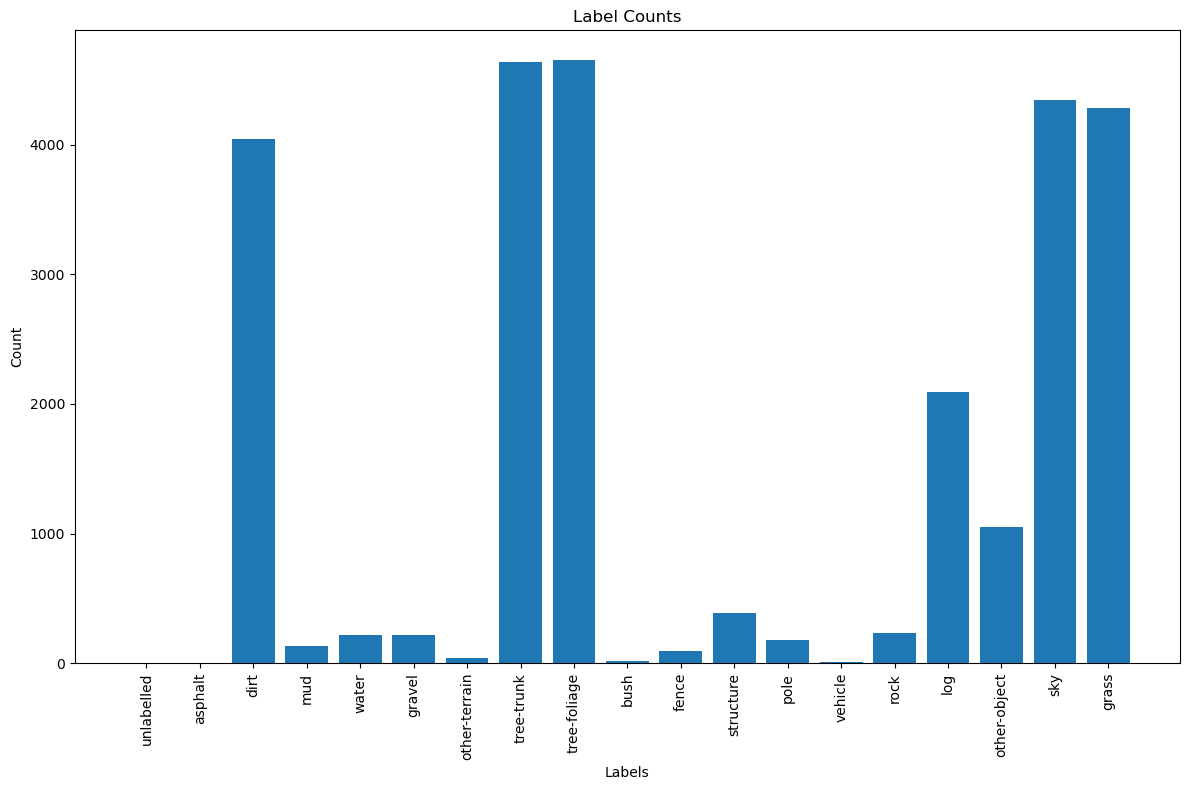

In [17]:
# Call the function with the path to the CSV file
plot_label_counts('./sampled_data.csv',classes)

In [18]:
#split into train.csv val.csv test.csv
import pandas as pd
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# Read the CSV file
data = pd.read_csv('./sampled_data.csv')

# Define the list of classes
classes = [
    "unlabelled",
    "asphalt",
    "dirt",
    "mud",
    "water",
    "gravel",
    "other-terrain",
    "tree-trunk",
    "tree-foliage",
    "bush",
    "fence",
    "structure",
    "pole",
    "vehicle",
    "rock",
    "log",
    "other-object",
    "sky",
    "grass",
]

# Clean the labels data
data['labels'] = data['labels'].apply(lambda x: x.strip("()").replace("'", "").split(', '))

# Convert the labels to a binary matrix
mlb = MultiLabelBinarizer(classes=classes)
y = mlb.fit_transform(data['labels'])

# Extract the file paths
X = data[['id', 'im_path', 'label_path']].values

# Define the proportions for train, validation, and test sets
train_size = 0.7
validation_size = 0.05
test_size = 0.25

# Split the data into training and remaining sets
X_train, y_train, X_remaining, y_remaining = iterative_train_test_split(X, y, 0.3)

# Calculate the adjusted validation size based on remaining data
validation_size_adjusted = validation_size / (validation_size + test_size)

# Split the remaining data into validation and test sets
X_validation, y_validation, X_test, y_test = iterative_train_test_split(X_remaining, y_remaining, validation_size_adjusted)

# Convert the results back to DataFrame for inspection
train_data = pd.DataFrame(X_train, columns=['id', 'im_path', 'label_path'])
train_labels = pd.DataFrame(y_train, columns=mlb.classes_)

validation_data = pd.DataFrame(X_validation, columns=['id', 'im_path', 'label_path'])
validation_labels = pd.DataFrame(y_validation, columns=mlb.classes_)

test_data = pd.DataFrame(X_test, columns=['id', 'im_path', 'label_path'])
test_labels = pd.DataFrame(y_test, columns=mlb.classes_)

# Merge labels with the data
train_data = pd.concat([train_data, train_labels], axis=1)
validation_data = pd.concat([validation_data, validation_labels], axis=1)
test_data = pd.concat([test_data, test_labels], axis=1)

# Save the splits to CSV files
train_data.to_csv('./train.csv', index=False)
validation_data.to_csv('./val.csv', index=False)
test_data.to_csv('./test.csv', index=False)

print("Training set saved to train.csv")
print("Validation set saved to val.csv")
print("Test set saved to test.csv")
print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(validation_data)}")
print(f"Test size: {len(test_data)}")

Training set saved to train.csv
Validation set saved to val.csv
Test set saved to test.csv
Train size: 3287
Validation size: 1139
Test size: 227


In [19]:
def plot_label_counts_new_format(csv_file, classes,title):
    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Sum each column corresponding to a label to get the count of each label
    label_counts = {label: df[label].sum() for label in classes}

    # Create a list of counts in the order of the provided classes
    counts = [label_counts[label] for label in classes]

    # Plot the label counts
    plt.figure(figsize=(12, 8))
    plt.bar(classes, counts)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title(f'{title} Label Counts')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

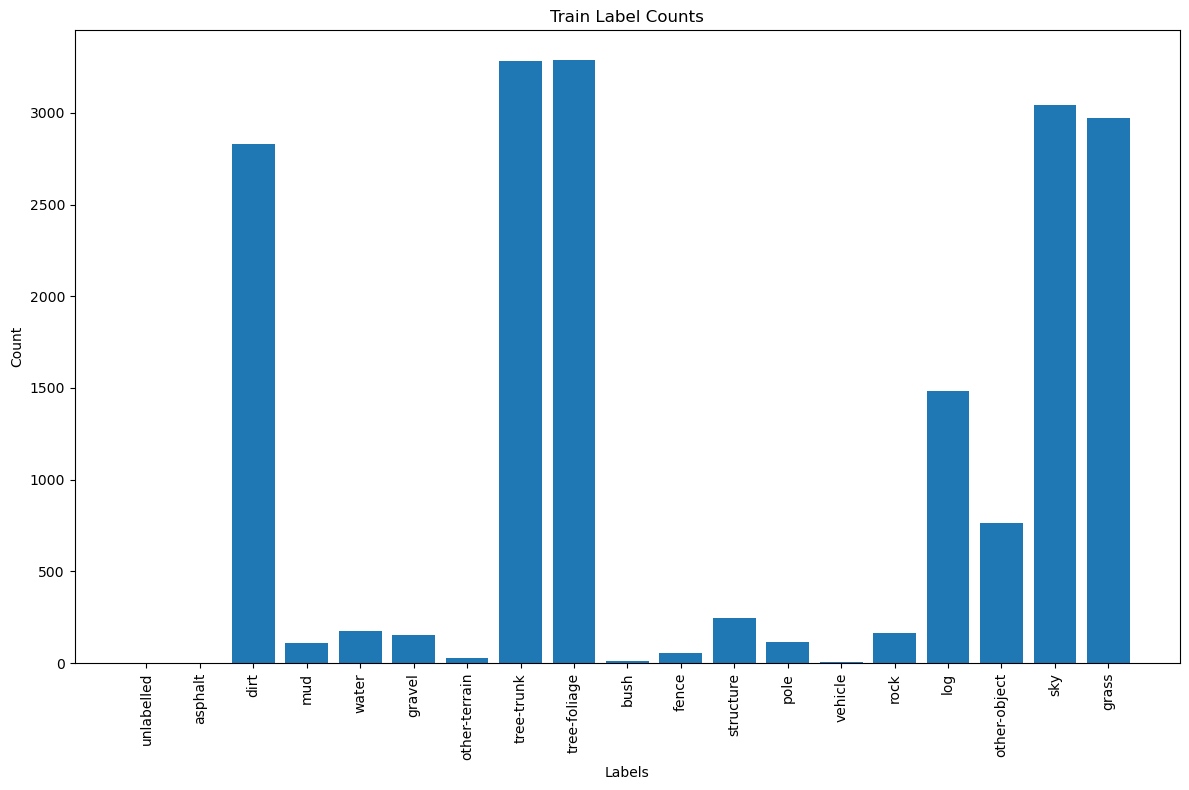

In [20]:
plot_label_counts_new_format("train.csv", classes,"Train")

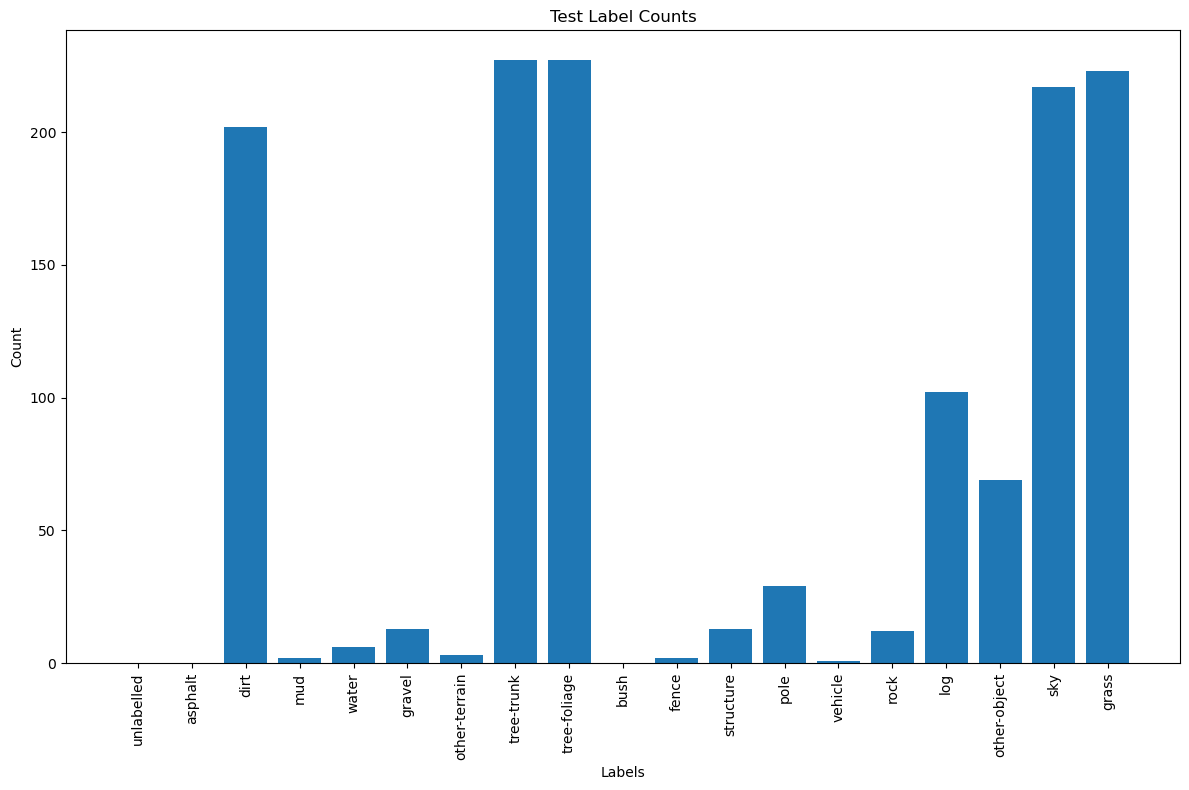

In [21]:
plot_label_counts_new_format("test.csv", classes,"Test")

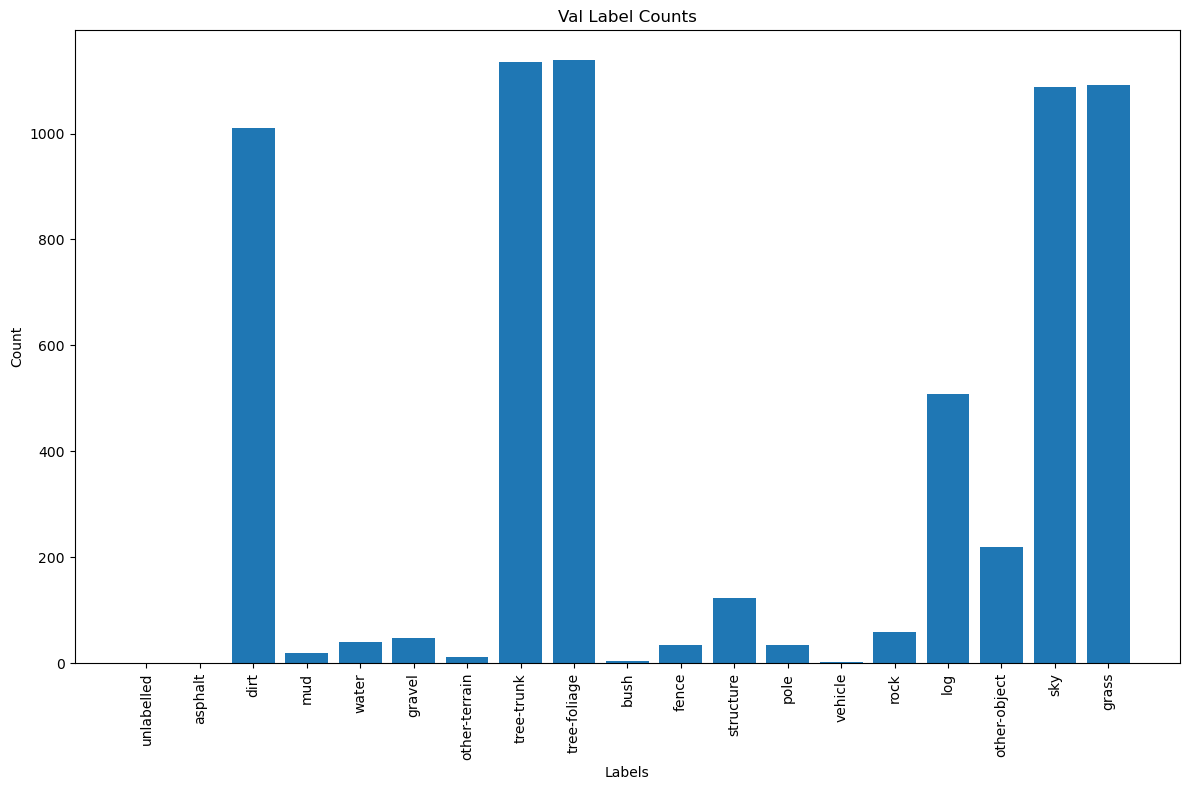

In [22]:
plot_label_counts_new_format("val.csv", classes,"Val")

In [23]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models

# METAINFO dictionary as provided
METAINFO = {
    "classes": (
        "dirt",
        "mud",
        "water",
        "gravel",
        "other-terrain",
        "tree-trunk",
        "tree-foliage",
        "bush",
        "fence",
        "structure",
        "pole",
        "vehicle",
        "rock",
        "log",
        "other-object",
        "sky",
        "grass",
    ),
    "palette": [
        (60, 180, 75),
        (255, 225, 25),
        (0, 130, 200),
        (145, 30, 180),
        (70, 240, 240),
        (240, 50, 230),
        (210, 245, 60),
        (230, 25, 75),
        (0, 128, 128),
        (170, 110, 40),
        (255, 250, 200),
        (128, 0, 0),
        (170, 255, 195),
        (128, 128, 0),
        (250, 190, 190),
        (0, 0, 128),
        (128, 128, 128),
    ],
    "cidx": list(range(19))
}

# Create mapping dictionaries
palette_to_cidx = {tuple(rgb): idx for idx, rgb in enumerate(METAINFO['palette'])}
num_classes = len(palette_to_cidx)

In [24]:
class JointTransform:
    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, image, mask):
        # Apply the base transform to the image
        image = self.base_transform(image)
        # Resize mask without using the base transform
        mask = mask.resize((256, 256), Image.NEAREST)
        # Convert mask to numpy array
        mask = np.array(mask)
        # Map RGB values to class indices
        mask = np.apply_along_axis(lambda x: palette_to_cidx.get(tuple(x), 0), 2, mask)  # <--- Changed
        # Ensure mask is of shape [height, width]
        mask = mask.astype(np.int64)
        # Convert mask to tensor
        mask = torch.tensor(mask, dtype=torch.long)
        return image, mask

class SegmentationDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir.rstrip('/') + '/'
        self.transform = transform
        self.binary_attrs = ['dirt', 'mud', 'water', 'gravel', 'other-terrain', 'tree-trunk', 'tree-foliage',
                             'bush', 'fence', 'structure', 'pole', 'vehicle', 'rock', 'log', 'other-object', 'sky', 'grass']

        # Preload all images and masks
        self.images = []
        self.masks = []
        self.attributes = []
        self._load_data()

    def _load_data(self):
        for idx in range(len(self.data_frame)):
            image_path = self.root_dir + self.data_frame.iloc[idx]['im_path'].lstrip('/')
            mask_path = self.root_dir + self.data_frame.iloc[idx]['label_path'].lstrip('/')

            # Check if the files exist
            if not os.path.exists(image_path):
                raise FileNotFoundError(f"Image file not found: {image_path}")
            if not os.path.exists(mask_path):
                raise FileNotFoundError(f"Mask file not found: {mask_path}")

            image = Image.open(image_path).convert("RGB")
            mask = Image.open(mask_path).convert("RGB")  # Keep as RGB to map to class indices

            if self.transform:
                image, mask = self.transform(image, mask)

            attributes = self.data_frame.iloc[idx][self.binary_attrs].values.astype(int)

            self.images.append(image)
            self.masks.append(mask)
            self.attributes.append(attributes)

            # Print message to indicate processing of each image
            print(f"Processed image {idx + 1}/{len(self.data_frame)}: {image_path}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.masks[idx], self.attributes[idx]


In [25]:
import pickle
from torch.utils.data import DataLoader
from torchvision import transforms
# Define the transformations
base_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize images to 256x256
    transforms.ToTensor(),          # Convert images to tensors
])

joint_transform = JointTransform(base_transform)

# Normalize images separately
normalize_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Paths to the CSV files
train_csv = './train.csv'
val_csv = './val.csv'
test_csv = './test.csv'

# Root folder for the images and masks
root_folder = './'

# Instantiate the datasets
train_dataset = SegmentationDataset(train_csv, root_folder, transform=joint_transform)
val_dataset = SegmentationDataset(val_csv, root_folder, transform=joint_transform)
test_dataset = SegmentationDataset(test_csv, root_folder, transform=joint_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False) 



Processed image 1/3287: ././sample/images\1623370408-092005506.png
Processed image 2/3287: ././sample/images\1623370419-079891555.png
Processed image 3/3287: ././sample/images\1623370431-877034758.png
Processed image 4/3287: ././sample/images\1623370450-035269387.png
Processed image 5/3287: ././sample/images\1623370456-801149630.png
Processed image 6/3287: ././sample/images\1623370470-804233922.png
Processed image 7/3287: ././sample/images\1623370483-400342824.png
Processed image 8/3287: ././sample/images\1623370489-765419840.png
Processed image 9/3287: ././sample/images\1623370499-480522421.png
Processed image 10/3287: ././sample/images\1623370507-521213401.png
Processed image 11/3287: ././sample/images\1623370519-178648201.png
Processed image 12/3287: ././sample/images\1623370537-134741275.png
Processed image 13/3287: ././sample/images\1623370549-798036254.png
Processed image 14/3287: ././sample/images\1623370563-532882631.png
Processed image 15/3287: ././sample/images\1623370577-402

In [26]:
#define the plot function on the first 5 images in testloader, and out put the overall miou on the entire testdata
import torch
import numpy as np
import matplotlib.pyplot as plt

def calculate_iou(pred, target, num_classes):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)
    
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds[target_inds]).long().sum().item()  # Cast to long to prevent overflow
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection
        
        if union != 0:
            ious.append(float(intersection) / float(max(union, 1)))
    return ious, np.mean(ious)

def visualize_predictions(model, test_loader, device, num_examples=5, num_classes=21, title=''):
    model.eval()
    test_images, test_masks, test_predictions = [], [], []
    all_ious = []
    mean_ious = []

    with torch.no_grad():
        for i, (images, masks, _) in enumerate(test_loader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            if i < num_examples:
                test_images.append(images.cpu()[0])
                test_masks.append(masks.cpu()[0])
                test_predictions.append(preds.cpu()[0])

            # Calculate IoU and mIoU
            ious, mean_iou = calculate_iou(preds.cpu(), masks.cpu(), num_classes)
            all_ious.append(ious)
            mean_ious.append(mean_iou)

    # Calculate overall mIoU
    overall_miou = np.mean(mean_ious)

    # Plotting the results
    fig, axs = plt.subplots(num_examples, 3, figsize=(15, num_examples * 5))
    for i in range(num_examples):
        axs[i, 0].imshow(test_images[i].permute(1, 2, 0))
        axs[i, 0].set_title("Original Image")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(test_masks[i], cmap='tab20', vmin=0, vmax=num_classes-1)
        axs[i, 1].set_title("Ground Truth Mask")
        axs[i, 1].axis('off')

        axs[i, 2].imshow(test_predictions[i], cmap='tab20', vmin=0, vmax=num_classes-1)
        axs[i, 2].set_title("Predicted Mask")
        axs[i, 2].axis('off')

    fig.suptitle(f'Performance on {title}\nOverall mIoU: {100*overall_miou:.2f}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()


In [27]:
#define the function to plot the iou on each labels
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def calculate_iou_per_class(pred, target, num_classes):
    ious = np.zeros(num_classes)
    pred = pred.view(-1)
    target = target.view(-1)
    
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds[target_inds]).long().sum().item()  # Cast to long to prevent overflow
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection
        
        if union != 0:
            ious[cls] = float(intersection) / float(max(union, 1))
    return ious

def evaluate_model_performance(model, test_loader, device, num_classes):
    model.eval()
    class_ious = np.zeros(num_classes)
    num_batches = 0

    with torch.no_grad():
        for images, masks, _ in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            ious = calculate_iou_per_class(preds.cpu(), masks.cpu(), num_classes)
            class_ious += ious
            num_batches += 1

    class_ious /= num_batches
    return class_ious

def plot_iou_table(class_ious, class_labels, method_name):
    # Create a DataFrame for better visualization
    df = pd.DataFrame({'Class': class_labels, 'IoU': class_ious})
    df.loc['mIoU'] = ['Overall mIoU', np.mean(class_ious)]
    
    # Plotting the table
    fig, ax = plt.subplots(figsize=(12, 8)) # set size frame
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc = 'center', loc='center', colColours =["palegreen"] * df.shape[1])
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(12)
    the_table.scale(1.2, 1.2)
    plt.title(f'IoU for each class - {method_name}', fontsize=16)
    plt.show()

In [28]:
# Define DeepLabv3 model architecture
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.atrous_block1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.atrous_block6 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=6, dilation=6)
        self.atrous_block12 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=12, dilation=12)
        self.atrous_block18 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=18, dilation=18)
        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
        nn.Conv2d(in_channels, out_channels, kernel_size=1))

    def forward(self, x):
        x1 = self.atrous_block1(x)
        x2 = self.atrous_block6(x)
        x3 = self.atrous_block12(x)
        x4 = self.atrous_block18(x)
        x5 = self.global_avg_pool(x)
        x5 = nn.functional.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)
        return torch.cat((x1, x2, x3, x4, x5), dim=1)

class DeepLabv3(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabv3, self).__init__()
        self.backbone = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.aspp = ASPP(in_channels=2048, out_channels=256)
        self.classifier = nn.Conv2d(1280, num_classes, kernel_size=1)

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        x = self.aspp(x)
        x = self.classifier(x)
        return nn.functional.interpolate(x, size=(256, 256), mode='bilinear', align_corners=True)


Using device: cuda


Epoch 1/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:23<00:00,  2.86it/s]


Epoch 1/25, Train Loss: 0.6035046282330859, Train mIoU: 0.6318232548202228


Validation Epoch 1/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:21<00:00,  6.60it/s]


Epoch 1/25, Val Loss: 0.48501843443283665, Val mIoU: 0.7048784745525256


Epoch 2/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 2/25, Train Loss: 0.49328462340825957, Train mIoU: 0.6633113905356885


Validation Epoch 2/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:22<00:00,  6.30it/s]


Epoch 2/25, Val Loss: 0.4646185180107197, Val mIoU: 0.71227557686387


Epoch 3/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.95it/s]


Epoch 3/25, Train Loss: 0.45482330267156706, Train mIoU: 0.6823952673474705


Validation Epoch 3/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:21<00:00,  6.60it/s]


Epoch 3/25, Val Loss: 0.4696698192949895, Val mIoU: 0.7111796673351337


Epoch 4/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.93it/s]


Epoch 4/25, Train Loss: 0.42155418974639725, Train mIoU: 0.7034672477413189


Validation Epoch 4/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:22<00:00,  6.37it/s]


Epoch 4/25, Val Loss: 0.4761351844022324, Val mIoU: 0.7162122675029132


Epoch 5/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 5/25, Train Loss: 0.39080025832148363, Train mIoU: 0.7262518293850567


Validation Epoch 5/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:22<00:00,  6.30it/s]


Epoch 5/25, Val Loss: 0.47315232476571223, Val mIoU: 0.7124649782946704


Epoch 6/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.95it/s]


Epoch 6/25, Train Loss: 0.3685334337888843, Train mIoU: 0.7437489100480191


Validation Epoch 6/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:22<00:00,  6.42it/s]


Epoch 6/25, Val Loss: 0.4875679867459344, Val mIoU: 0.7180734710811597


Epoch 7/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 7/25, Train Loss: 0.3529269123889524, Train mIoU: 0.7504487445352421


Validation Epoch 7/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:22<00:00,  6.40it/s]


Epoch 7/25, Val Loss: 0.4874637774028978, Val mIoU: 0.7185480825885353


Epoch 8/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.93it/s]


Epoch 8/25, Train Loss: 0.3414630339528522, Train mIoU: 0.7582121050998053


Validation Epoch 8/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:21<00:00,  6.53it/s]


Epoch 8/25, Val Loss: 0.49601148527402145, Val mIoU: 0.6926884450865207


Epoch 9/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:23<00:00,  2.86it/s]


Epoch 9/25, Train Loss: 0.3290741173890385, Train mIoU: 0.7675011508467775


Validation Epoch 9/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:22<00:00,  6.49it/s]


Epoch 9/25, Val Loss: 0.49842898224617216, Val mIoU: 0.7173434794512048


Epoch 10/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.92it/s]


Epoch 10/25, Train Loss: 0.32264054466918146, Train mIoU: 0.7736816435138807


Validation Epoch 10/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:21<00:00,  6.59it/s]


Epoch 10/25, Val Loss: 0.5093587761992341, Val mIoU: 0.7167242499779719


Epoch 11/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 11/25, Train Loss: 0.31529863425269905, Train mIoU: 0.7787183089896008


Validation Epoch 11/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:22<00:00,  6.49it/s]


Epoch 11/25, Val Loss: 0.5058083647823001, Val mIoU: 0.6981225548210803


Epoch 12/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 12/25, Train Loss: 0.30999931149239085, Train mIoU: 0.7828261428332692


Validation Epoch 12/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:21<00:00,  6.54it/s]


Epoch 12/25, Val Loss: 0.5171118567248324, Val mIoU: 0.7306300593765245


Epoch 13/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.92it/s]


Epoch 13/25, Train Loss: 0.3047920818238943, Train mIoU: 0.7843740682990353


Validation Epoch 13/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:22<00:00,  6.46it/s]


Epoch 13/25, Val Loss: 0.525908523402014, Val mIoU: 0.7085419777312701


Epoch 14/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.98it/s]


Epoch 14/25, Train Loss: 0.3022237846813643, Train mIoU: 0.7823746303363074


Validation Epoch 14/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:21<00:00,  6.73it/s]


Epoch 14/25, Val Loss: 0.5276406226041434, Val mIoU: 0.7089228643760639


Epoch 15/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 15/25, Train Loss: 0.2994660067297246, Train mIoU: 0.7847872582245653


Validation Epoch 15/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:22<00:00,  6.27it/s]


Epoch 15/25, Val Loss: 0.5356674311044333, Val mIoU: 0.7160745952827411


Epoch 16/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:18<00:00,  2.97it/s]


Epoch 16/25, Train Loss: 0.2938522248372544, Train mIoU: 0.7931532411645744


Validation Epoch 16/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:22<00:00,  6.48it/s]


Epoch 16/25, Val Loss: 0.5316109097712524, Val mIoU: 0.7134242052580517


Epoch 17/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:18<00:00,  2.97it/s]


Epoch 17/25, Train Loss: 0.2905072969386757, Train mIoU: 0.7969846721723649


Validation Epoch 17/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:21<00:00,  6.54it/s]


Epoch 17/25, Val Loss: 0.5534864161814843, Val mIoU: 0.7213856904703859


Epoch 18/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 18/25, Train Loss: 0.28754928979995475, Train mIoU: 0.7979791635261511


Validation Epoch 18/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:21<00:00,  6.66it/s]


Epoch 18/25, Val Loss: 0.5485002293244942, Val mIoU: 0.7244963042624506


Epoch 19/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:18<00:00,  2.97it/s]


Epoch 19/25, Train Loss: 0.2957170906945737, Train mIoU: 0.790722754929327


Validation Epoch 19/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:22<00:00,  6.43it/s]


Epoch 19/25, Val Loss: 0.5437486886561333, Val mIoU: 0.7070644346673227


Epoch 20/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:18<00:00,  2.97it/s]


Epoch 20/25, Train Loss: 0.2969066677954945, Train mIoU: 0.7870697267609793


Validation Epoch 20/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:21<00:00,  6.80it/s]


Epoch 20/25, Val Loss: 0.5420295838917886, Val mIoU: 0.6944145024555016


Epoch 21/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 21/25, Train Loss: 0.28515961102760623, Train mIoU: 0.7990245961468224


Validation Epoch 21/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:22<00:00,  6.34it/s]


Epoch 21/25, Val Loss: 0.5592587303656799, Val mIoU: 0.7130488151472163


Epoch 22/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:18<00:00,  2.97it/s]


Epoch 22/25, Train Loss: 0.27750211276132114, Train mIoU: 0.8080268304467318


Validation Epoch 22/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:21<00:00,  6.80it/s]


Epoch 22/25, Val Loss: 0.5587287423285571, Val mIoU: 0.7151217058254569


Epoch 23/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:18<00:00,  2.97it/s]


Epoch 23/25, Train Loss: 0.2748961209018155, Train mIoU: 0.8090303743041383


Validation Epoch 23/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:19<00:00,  7.20it/s]


Epoch 23/25, Val Loss: 0.5780955068506561, Val mIoU: 0.7243979329809757


Epoch 24/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.95it/s]


Epoch 24/25, Train Loss: 0.2742898627354281, Train mIoU: 0.8098044219436871


Validation Epoch 24/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:21<00:00,  6.76it/s]


Epoch 24/25, Val Loss: 0.577850827074551, Val mIoU: 0.7138074414724922


Epoch 25/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.95it/s]


Epoch 25/25, Train Loss: 0.27355824407289786, Train mIoU: 0.8131489284452098


Validation Epoch 25/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:21<00:00,  6.59it/s]


Epoch 25/25, Val Loss: 0.5769101001999595, Val mIoU: 0.7189383535623733
Model saved to deeplab.pth


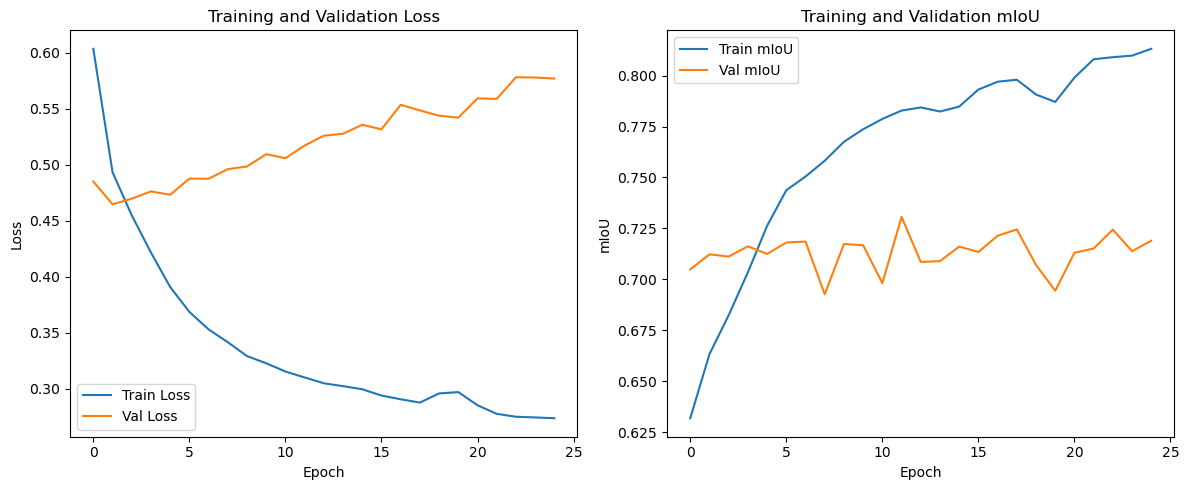

In [29]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Define the loss function and optimizer for DeepLabv3
deeplab_model = DeepLabv3(num_classes=len(palette_to_cidx)).to('cuda' if torch.cuda.is_available() else 'cpu')  # Adjust number of classes
deeplab_criterion = nn.CrossEntropyLoss()
deeplab_optimizer = optim.Adam(deeplab_model.parameters(), lr=1e-4)

def calculate_miou(outputs, masks, num_classes):
    _, preds = torch.max(outputs, 1)
    ious = []
    for cls in range(num_classes):
        intersection = ((preds == cls) & (masks == cls)).float().sum()
        union = ((preds == cls) | (masks == cls)).float().sum()
        if union == 0:
            ious.append(1.0)  # If there is no ground truth, consider it as a perfect IoU
        else:
            ious.append((intersection / union).item())
    return sum(ious) / len(ious)

# Training loop for DeepLabv3
def train_deeplab(model, train_loader, val_loader, num_epochs, device, num_classes):
    model.to(device)
    train_losses = []
    val_losses = []
    train_mious = []
    val_mious = []

    print(f"Using device: {device}")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_miou = 0.0
        for images, masks, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, masks = images.to(device), masks.to(device)  # Move to GPU if available

            deeplab_optimizer.zero_grad()
            outputs = model(images)

            loss = deeplab_criterion(outputs, masks)
            loss.backward()
            deeplab_optimizer.step()
            running_loss += loss.item()

            miou = calculate_miou(outputs, masks, num_classes)
            running_miou += miou

        train_losses.append(running_loss / len(train_loader))
        train_mious.append(running_miou / len(train_loader))
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss / len(train_loader)}, Train mIoU: {running_miou / len(train_loader)}')

        # Validation step
        model.eval()
        val_loss = 0.0
        val_miou = 0.0
        with torch.no_grad():
            for images, masks, _ in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                images, masks = images.to(device), masks.to(device)  # Move to GPU if available

                outputs = model(images)

                loss = deeplab_criterion(outputs, masks)
                val_loss += loss.item()

                miou = calculate_miou(outputs, masks, num_classes)
                val_miou += miou

        val_losses.append(val_loss / len(val_loader))
        val_mious.append(val_miou / len(val_loader))
        print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss / len(val_loader)}, Val mIoU: {val_miou / len(val_loader)}')

    return train_losses, val_losses, train_mious, val_mious

# Training the DeepLabv3 model
num_epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
num_classes = len(palette_to_cidx)  # Number of classes
deeplab_train_losses, deeplab_val_losses, deeplab_train_mious, deeplab_val_mious = train_deeplab(deeplab_model, train_loader, val_loader, num_epochs, device, num_classes)

# Save the trained SegFormerB2 model
model_save_path = 'deeplab.pth'
torch.save(deeplab_model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

# Plotting the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(deeplab_train_losses, label='Train Loss')
plt.plot(deeplab_val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(deeplab_train_mious, label='Train mIoU')
plt.plot(deeplab_val_mious, label='Val mIoU')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('Training and Validation mIoU')
plt.legend()

plt.tight_layout()
plt.show()


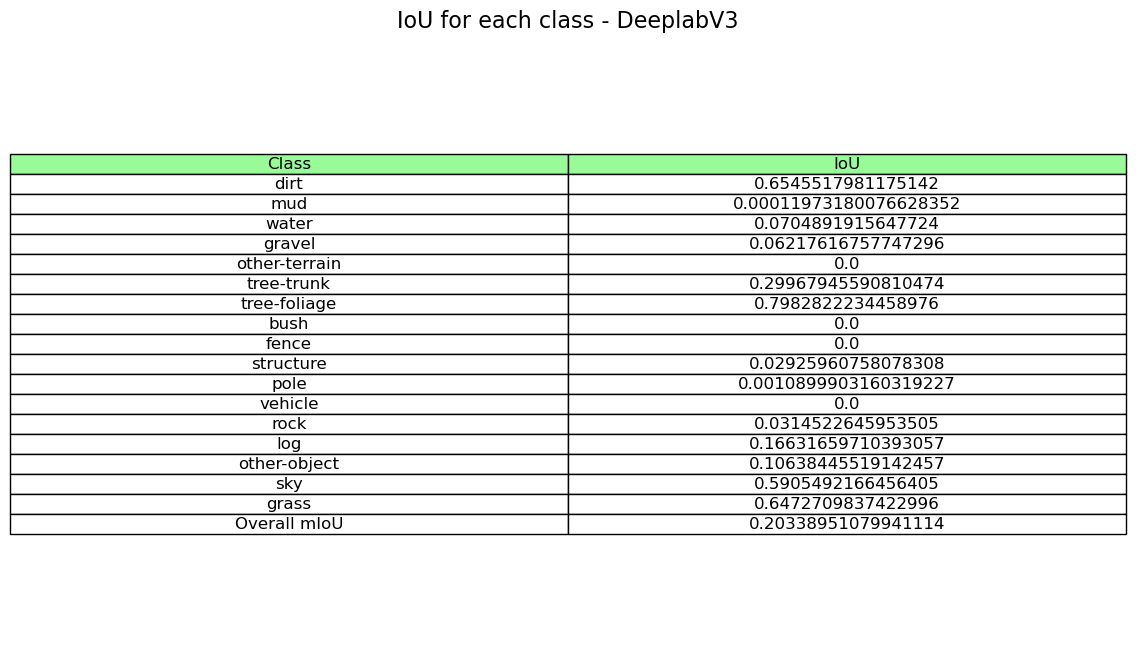

In [30]:
# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_labels = METAINFO["classes"]
num_classes = len(class_labels)

# Assuming you have a test_loader and a trained model
class_ious = evaluate_model_performance(deeplab_model, test_loader, device, num_classes=num_classes)
plot_iou_table(class_ious, class_labels, method_name='DeeplabV3')

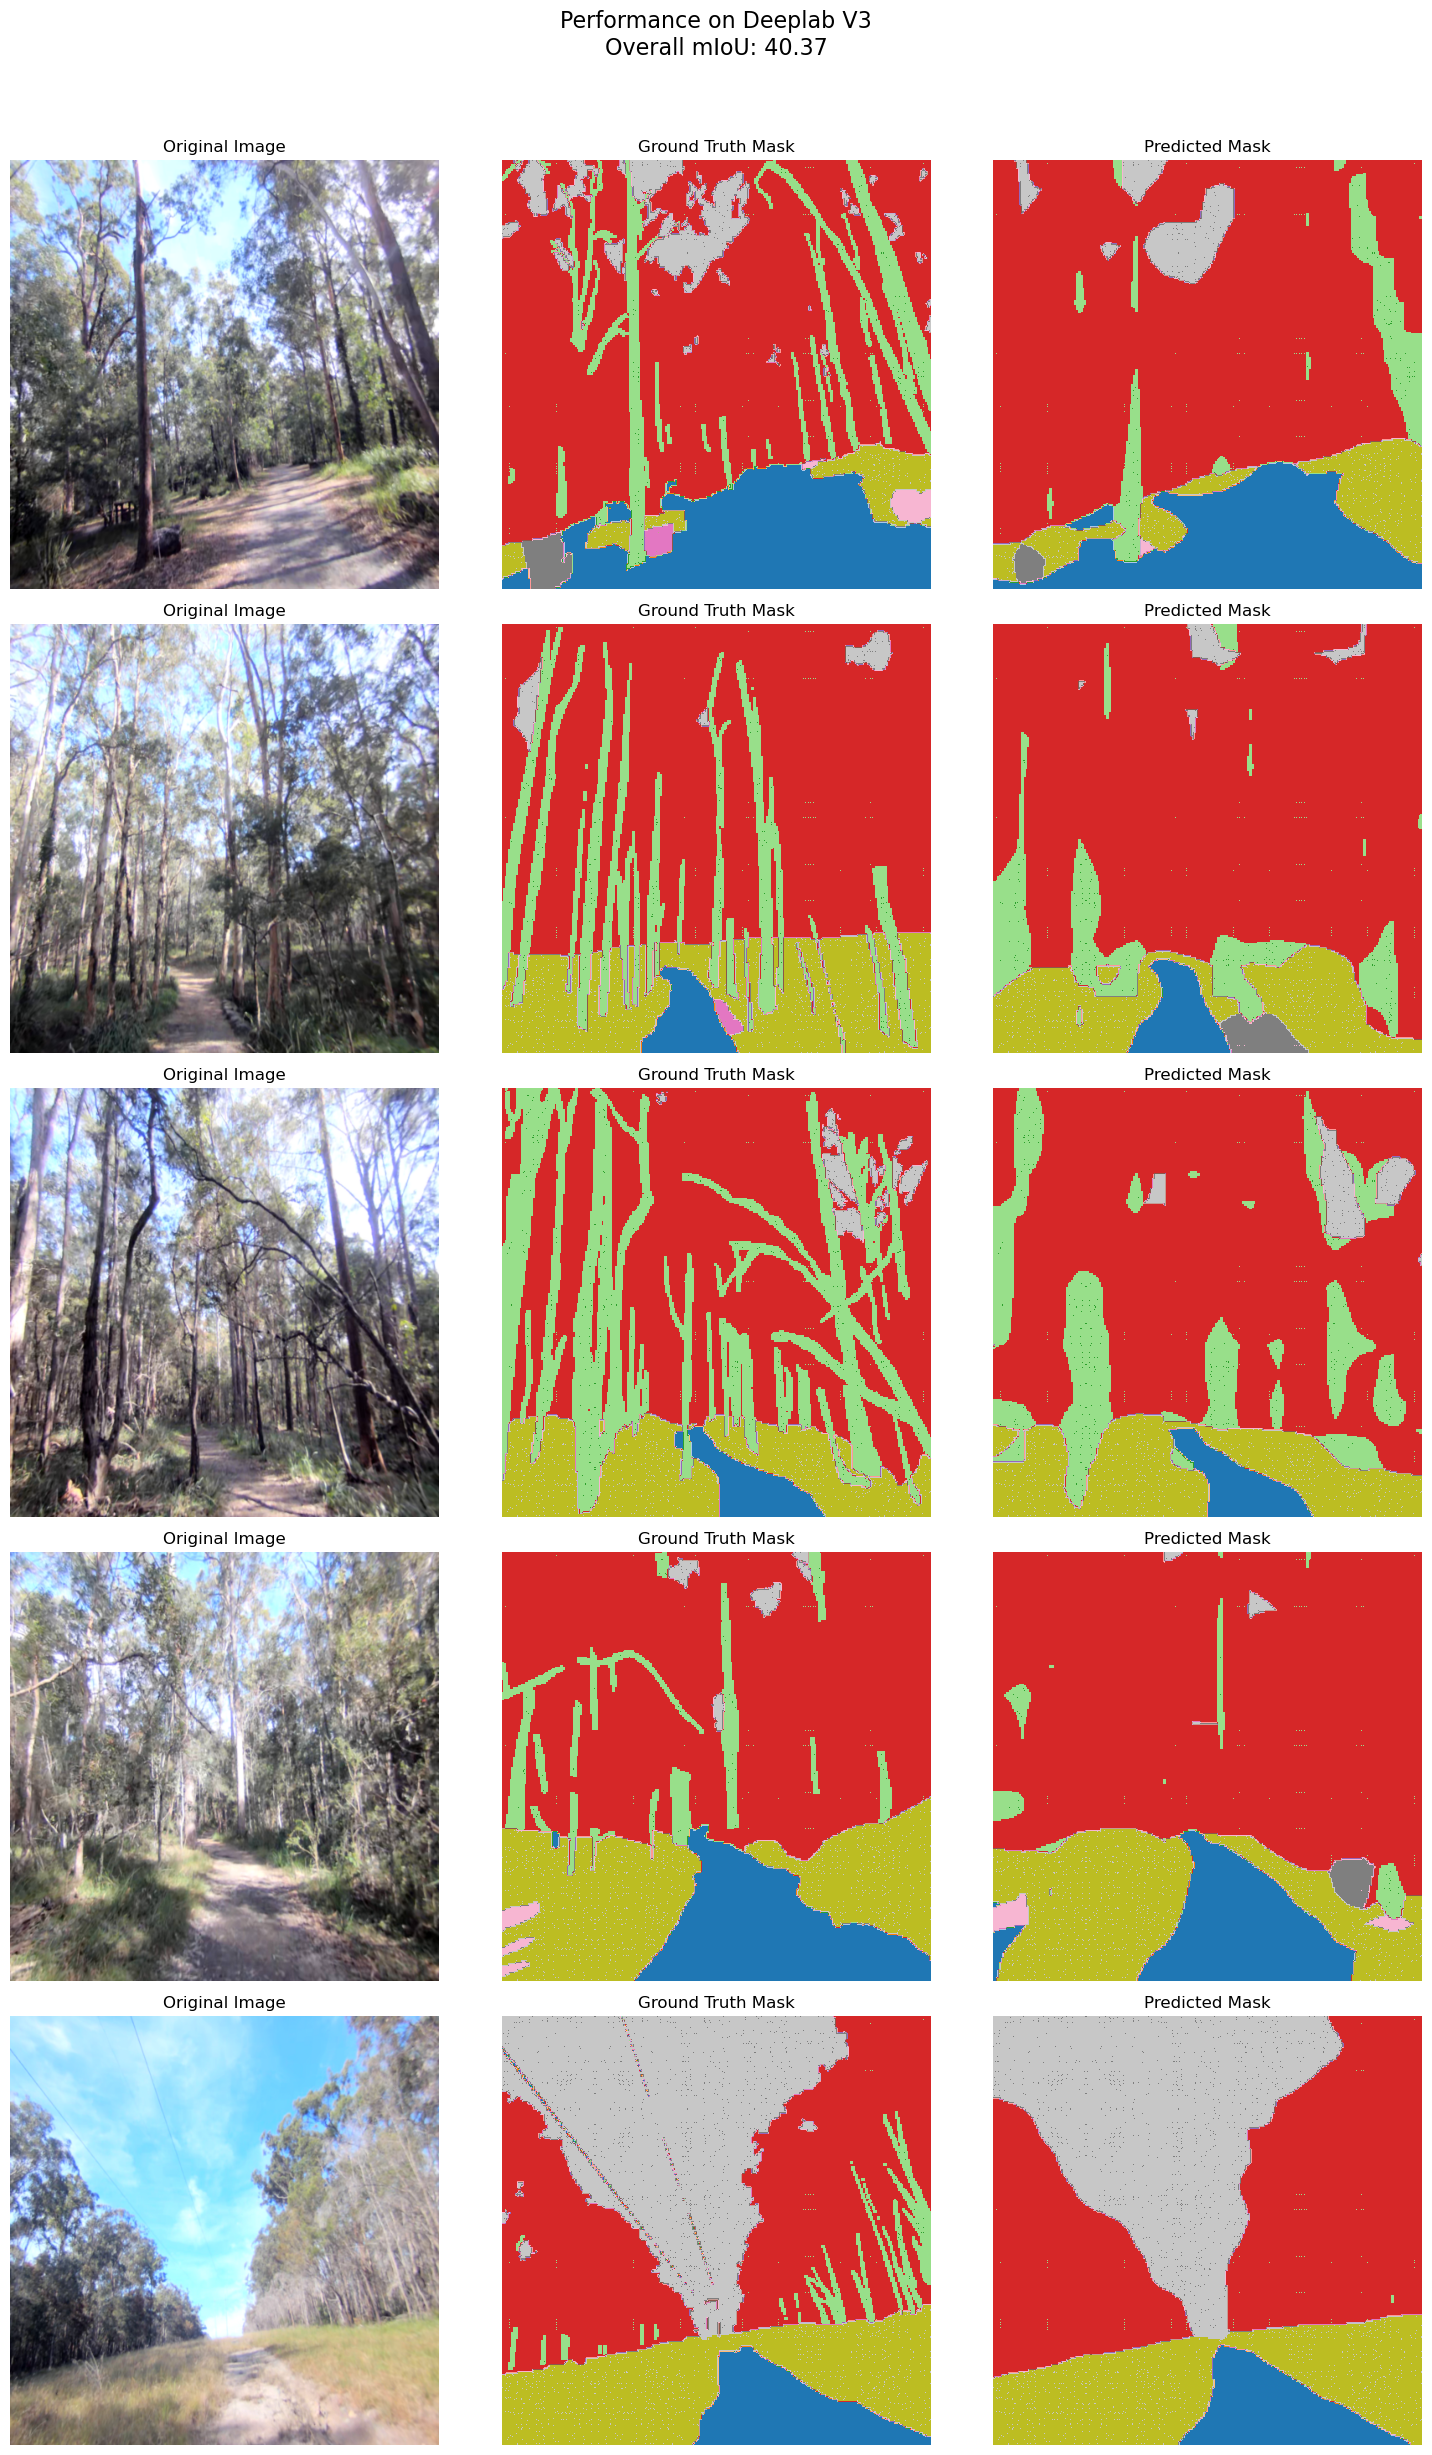

In [31]:
# Run inference and visualize the results
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_predictions(deeplab_model, test_loader, device, num_examples=5, num_classes=21,title='Deeplab V3')

In [32]:
#Free the GPU Memory
import torch
import gc
del deeplab_criterion
del deeplab_model
del deeplab_optimizer

gc.collect()
# free memory
torch.cuda.empty_cache()


Epoch 1/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:30<00:00,  2.73it/s]


Epoch 1/15, Train Loss: 1.9372952341163245, Train mIoU: 0.5352160026581514


Validation Epoch 1/15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:24<00:00,  5.90it/s]


Epoch 1/15, Val Loss: 1.2537264298725794, Val mIoU: 0.7422601871768001


Epoch 2/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:28<00:00,  2.76it/s]


Epoch 2/15, Train Loss: 0.9781192732553412, Train mIoU: 0.70438459066238


Validation Epoch 2/15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:24<00:00,  5.84it/s]


Epoch 2/15, Val Loss: 0.7505596155053252, Val mIoU: 0.7596401789802206


Epoch 3/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:28<00:00,  2.76it/s]


Epoch 3/15, Train Loss: 0.7140792862052175, Train mIoU: 0.7151273813059954


Validation Epoch 3/15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:24<00:00,  5.87it/s]


Epoch 3/15, Val Loss: 0.6077023925897959, Val mIoU: 0.7749523999821869


Epoch 4/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:30<00:00,  2.73it/s]


Epoch 4/15, Train Loss: 0.6218624490601012, Train mIoU: 0.71860006943592


Validation Epoch 4/15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:25<00:00,  5.62it/s]


Epoch 4/15, Val Loss: 0.5470476352668309, Val mIoU: 0.7777300721114052


Epoch 5/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:29<00:00,  2.75it/s]


Epoch 5/15, Train Loss: 0.5751486296636344, Train mIoU: 0.7205435046833358


Validation Epoch 5/15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:25<00:00,  5.69it/s]


Epoch 5/15, Val Loss: 0.5307615970398163, Val mIoU: 0.7779658904872173


Epoch 6/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:28<00:00,  2.76it/s]


Epoch 6/15, Train Loss: 0.5438598884573238, Train mIoU: 0.7217429352910203


Validation Epoch 6/15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:24<00:00,  5.85it/s]


Epoch 6/15, Val Loss: 0.5118340374706508, Val mIoU: 0.7800008762020287


Epoch 7/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:31<00:00,  2.72it/s]


Epoch 7/15, Train Loss: 0.5214945378819812, Train mIoU: 0.726011081150392


Validation Epoch 7/15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:22<00:00,  6.34it/s]


Epoch 7/15, Val Loss: 0.48415339910067046, Val mIoU: 0.782278648321684


Epoch 8/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:30<00:00,  2.72it/s]


Epoch 8/15, Train Loss: 0.5033503629430367, Train mIoU: 0.7246307729409377


Validation Epoch 8/15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:25<00:00,  5.67it/s]


Epoch 8/15, Val Loss: 0.4812548810785467, Val mIoU: 0.7740664047781309


Epoch 9/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:29<00:00,  2.75it/s]


Epoch 9/15, Train Loss: 0.4902644941261505, Train mIoU: 0.7258825422544493


Validation Epoch 9/15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:21<00:00,  6.52it/s]


Epoch 9/15, Val Loss: 0.45895858202780876, Val mIoU: 0.7811942198906117


Epoch 10/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:30<00:00,  2.73it/s]


Epoch 10/15, Train Loss: 0.47520302087431116, Train mIoU: 0.7260890047664303


Validation Epoch 10/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:24<00:00,  5.93it/s]


Epoch 10/15, Val Loss: 0.46601817199400253, Val mIoU: 0.7701391072176017


Epoch 11/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:28<00:00,  2.77it/s]


Epoch 11/15, Train Loss: 0.45852993925412494, Train mIoU: 0.7240025301601871


Validation Epoch 11/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:24<00:00,  5.79it/s]


Epoch 11/15, Val Loss: 0.45374197413871337, Val mIoU: 0.7723406627872943


Epoch 12/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:29<00:00,  2.75it/s]


Epoch 12/15, Train Loss: 0.4487898250420888, Train mIoU: 0.7258672826300986


Validation Epoch 12/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:25<00:00,  5.72it/s]


Epoch 12/15, Val Loss: 0.4577406132137859, Val mIoU: 0.7669545862450823


Epoch 13/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:29<00:00,  2.75it/s]


Epoch 13/15, Train Loss: 0.4369197510309753, Train mIoU: 0.7276784573983894


Validation Epoch 13/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:24<00:00,  5.78it/s]


Epoch 13/15, Val Loss: 0.4704939029016695, Val mIoU: 0.7488363982514799


Epoch 14/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:31<00:00,  2.70it/s]


Epoch 14/15, Train Loss: 0.423843878754154, Train mIoU: 0.737373042993139


Validation Epoch 14/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:24<00:00,  5.81it/s]


Epoch 14/15, Val Loss: 0.4513350776233873, Val mIoU: 0.7754283153940987


Epoch 15/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [02:30<00:00,  2.73it/s]


Epoch 15/15, Train Loss: 0.41303616769412427, Train mIoU: 0.7392823574082424


Validation Epoch 15/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:25<00:00,  5.64it/s]


Epoch 15/15, Val Loss: 0.44524801777792977, Val mIoU: 0.7592481120226693
Model saved to segformer_b0.pth


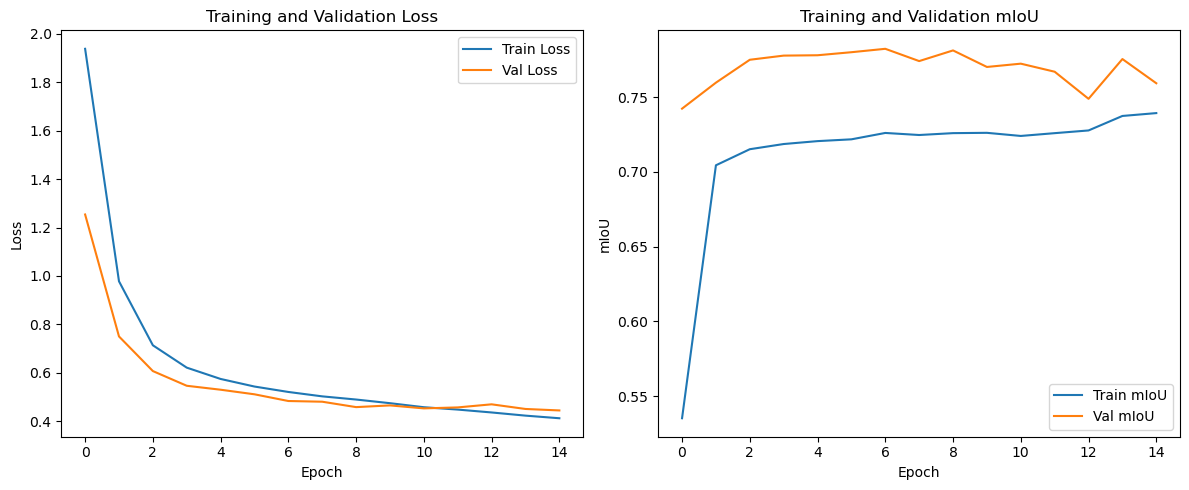

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Dropout
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // self.num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, C, H, W = x.shape  # 4D input
        x = x.permute(0, 2, 3, 1).reshape(B, H * W, C)  # Flatten spatial dimensions and permute to [B, N, C]
        qkv = self.qkv(x).reshape(B, -1, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, -1, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        x = x.reshape(B, H, W, C).permute(0, 3, 1, 2)  # Convert back to 4D
        return x

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1).reshape(B, -1, C)  # Flatten spatial dimensions and permute to [B, N, C]
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2)  # Convert back to 4D
        return x

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.BatchNorm2d):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
                              attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = nn.Identity() if drop_path == 0 else DropPath(drop_path)
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = self.norm1(x)
        x = x + self.drop_path(self.attn(x))
        x = self.norm2(x)
        x = x + self.drop_path(self.mlp(x))
        return x

class SegFormerBackboneB0(nn.Module):
    def __init__(self, num_classes):
        super(SegFormerBackboneB0, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            Block(dim=64, num_heads=1, norm_layer=nn.BatchNorm2d),
            Block(dim=64, num_heads=1, norm_layer=nn.BatchNorm2d),
            Block(dim=64, num_heads=1, norm_layer=nn.BatchNorm2d),
            Block(dim=64, num_heads=1, norm_layer=nn.BatchNorm2d)
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            Block(dim=128, num_heads=2, norm_layer=nn.BatchNorm2d),
            Block(dim=128, num_heads=2, norm_layer=nn.BatchNorm2d),
            Block(dim=128, num_heads=2, norm_layer=nn.BatchNorm2d),
            Block(dim=128, num_heads=2, norm_layer=nn.BatchNorm2d)
        )
        self.encoder4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            Block(dim=256, num_heads=4, norm_layer=nn.BatchNorm2d),
            Block(dim=256, num_heads=4, norm_layer=nn.BatchNorm2d),
            Block(dim=256, num_heads=4, norm_layer=nn.BatchNorm2d),
            Block(dim=256, num_heads=4, norm_layer=nn.BatchNorm2d)
        )

    def forward(self, x):
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)
        return x1, x2, x3, x4

class SegFormerB0(nn.Module):
    def __init__(self, num_classes):
        super(SegFormerB0, self).__init__()
        self.backbone = SegFormerBackboneB0(num_classes)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, num_classes, kernel_size=2, stride=2)
        )

    def forward(self, x):
        x1, x2, x3, x4 = self.backbone(x)
        output = self.decoder(x4)
        output = F.interpolate(output, size=(256, 256), mode='bilinear', align_corners=False)  # Upsample to match target size
        return output

# Define the loss function and optimizer for SegFormerB0
num_classes = 21  # Adjust the number of classes according to your dataset
segformer_model = SegFormerB0(num_classes=num_classes).to('cuda' if torch.cuda.is_available() else 'cpu')
segformer_criterion = nn.CrossEntropyLoss()
segformer_optimizer = torch.optim.Adam(segformer_model.parameters(), lr=1e-4)

def calculate_miou(outputs, masks, num_classes):
    _, preds = torch.max(outputs, 1)
    preds = preds.view(-1)
    masks = masks.view(-1)
    
    ious = []
    for cls in range(num_classes):
        intersection = ((preds == cls) & (masks == cls)).sum().float().item()
        union = ((preds == cls) | (masks == cls)).sum().float().item()
        if union != 0:
            ious.append(intersection / union)
        else:
            ious.append(1.0)  # If there is no ground truth, consider it as a perfect IoU
    return sum(ious) / len(ious)

# Training loop for SegFormerB0
def train_segformer(model, train_loader, val_loader, num_epochs, device, num_classes):
    model.to(device)
    train_losses = []
    val_losses = []
    train_mious = []
    val_mious = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_miou = 0.0
        for images, masks, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, masks = images.to(device), masks.to(device)  # Move to GPU if available

            segformer_optimizer.zero_grad()
            outputs = model(images)

            loss = segformer_criterion(outputs, masks)
            loss.backward()
            segformer_optimizer.step()
            running_loss += loss.item()

            miou = calculate_miou(outputs, masks, num_classes)
            running_miou += miou

        train_losses.append(running_loss / len(train_loader))
        train_mious.append(running_miou / len(train_loader))
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss / len(train_loader)}, Train mIoU: {running_miou / len(train_loader)}')

        # Validation step
        model.eval()
        val_loss = 0.0
        val_miou = 0.0
        with torch.no_grad():
            for images, masks, _ in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                images, masks = images.to(device), masks.to(device)  # Move to GPU if available

                outputs = model(images)

                loss = segformer_criterion(outputs, masks)
                val_loss += loss.item()

                miou = calculate_miou(outputs, masks, num_classes)
                val_miou += miou

        val_losses.append(val_loss / len(val_loader))
        val_mious.append(val_miou / len(val_loader))
        print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss / len(val_loader)}, Val mIoU: {val_miou / len(val_loader)}')

    return train_losses, val_losses, train_mious, val_mious

# Training the SegFormerB0 model
num_epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
segformer_train_losses, segformer_val_losses, segformer_train_mious, segformer_val_mious = train_segformer(segformer_model, train_loader, val_loader, num_epochs, device, num_classes)

# Save the trained SegFormerB0 model
model_save_path = 'segformer_b0.pth'
torch.save(segformer_model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

# Plotting the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(segformer_train_losses, label='Train Loss')
plt.plot(segformer_val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(segformer_train_mious, label='Train mIoU')
plt.plot(segformer_val_mious, label='Val mIoU')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('Training and Validation mIoU')
plt.legend()

plt.tight_layout()
plt.show()


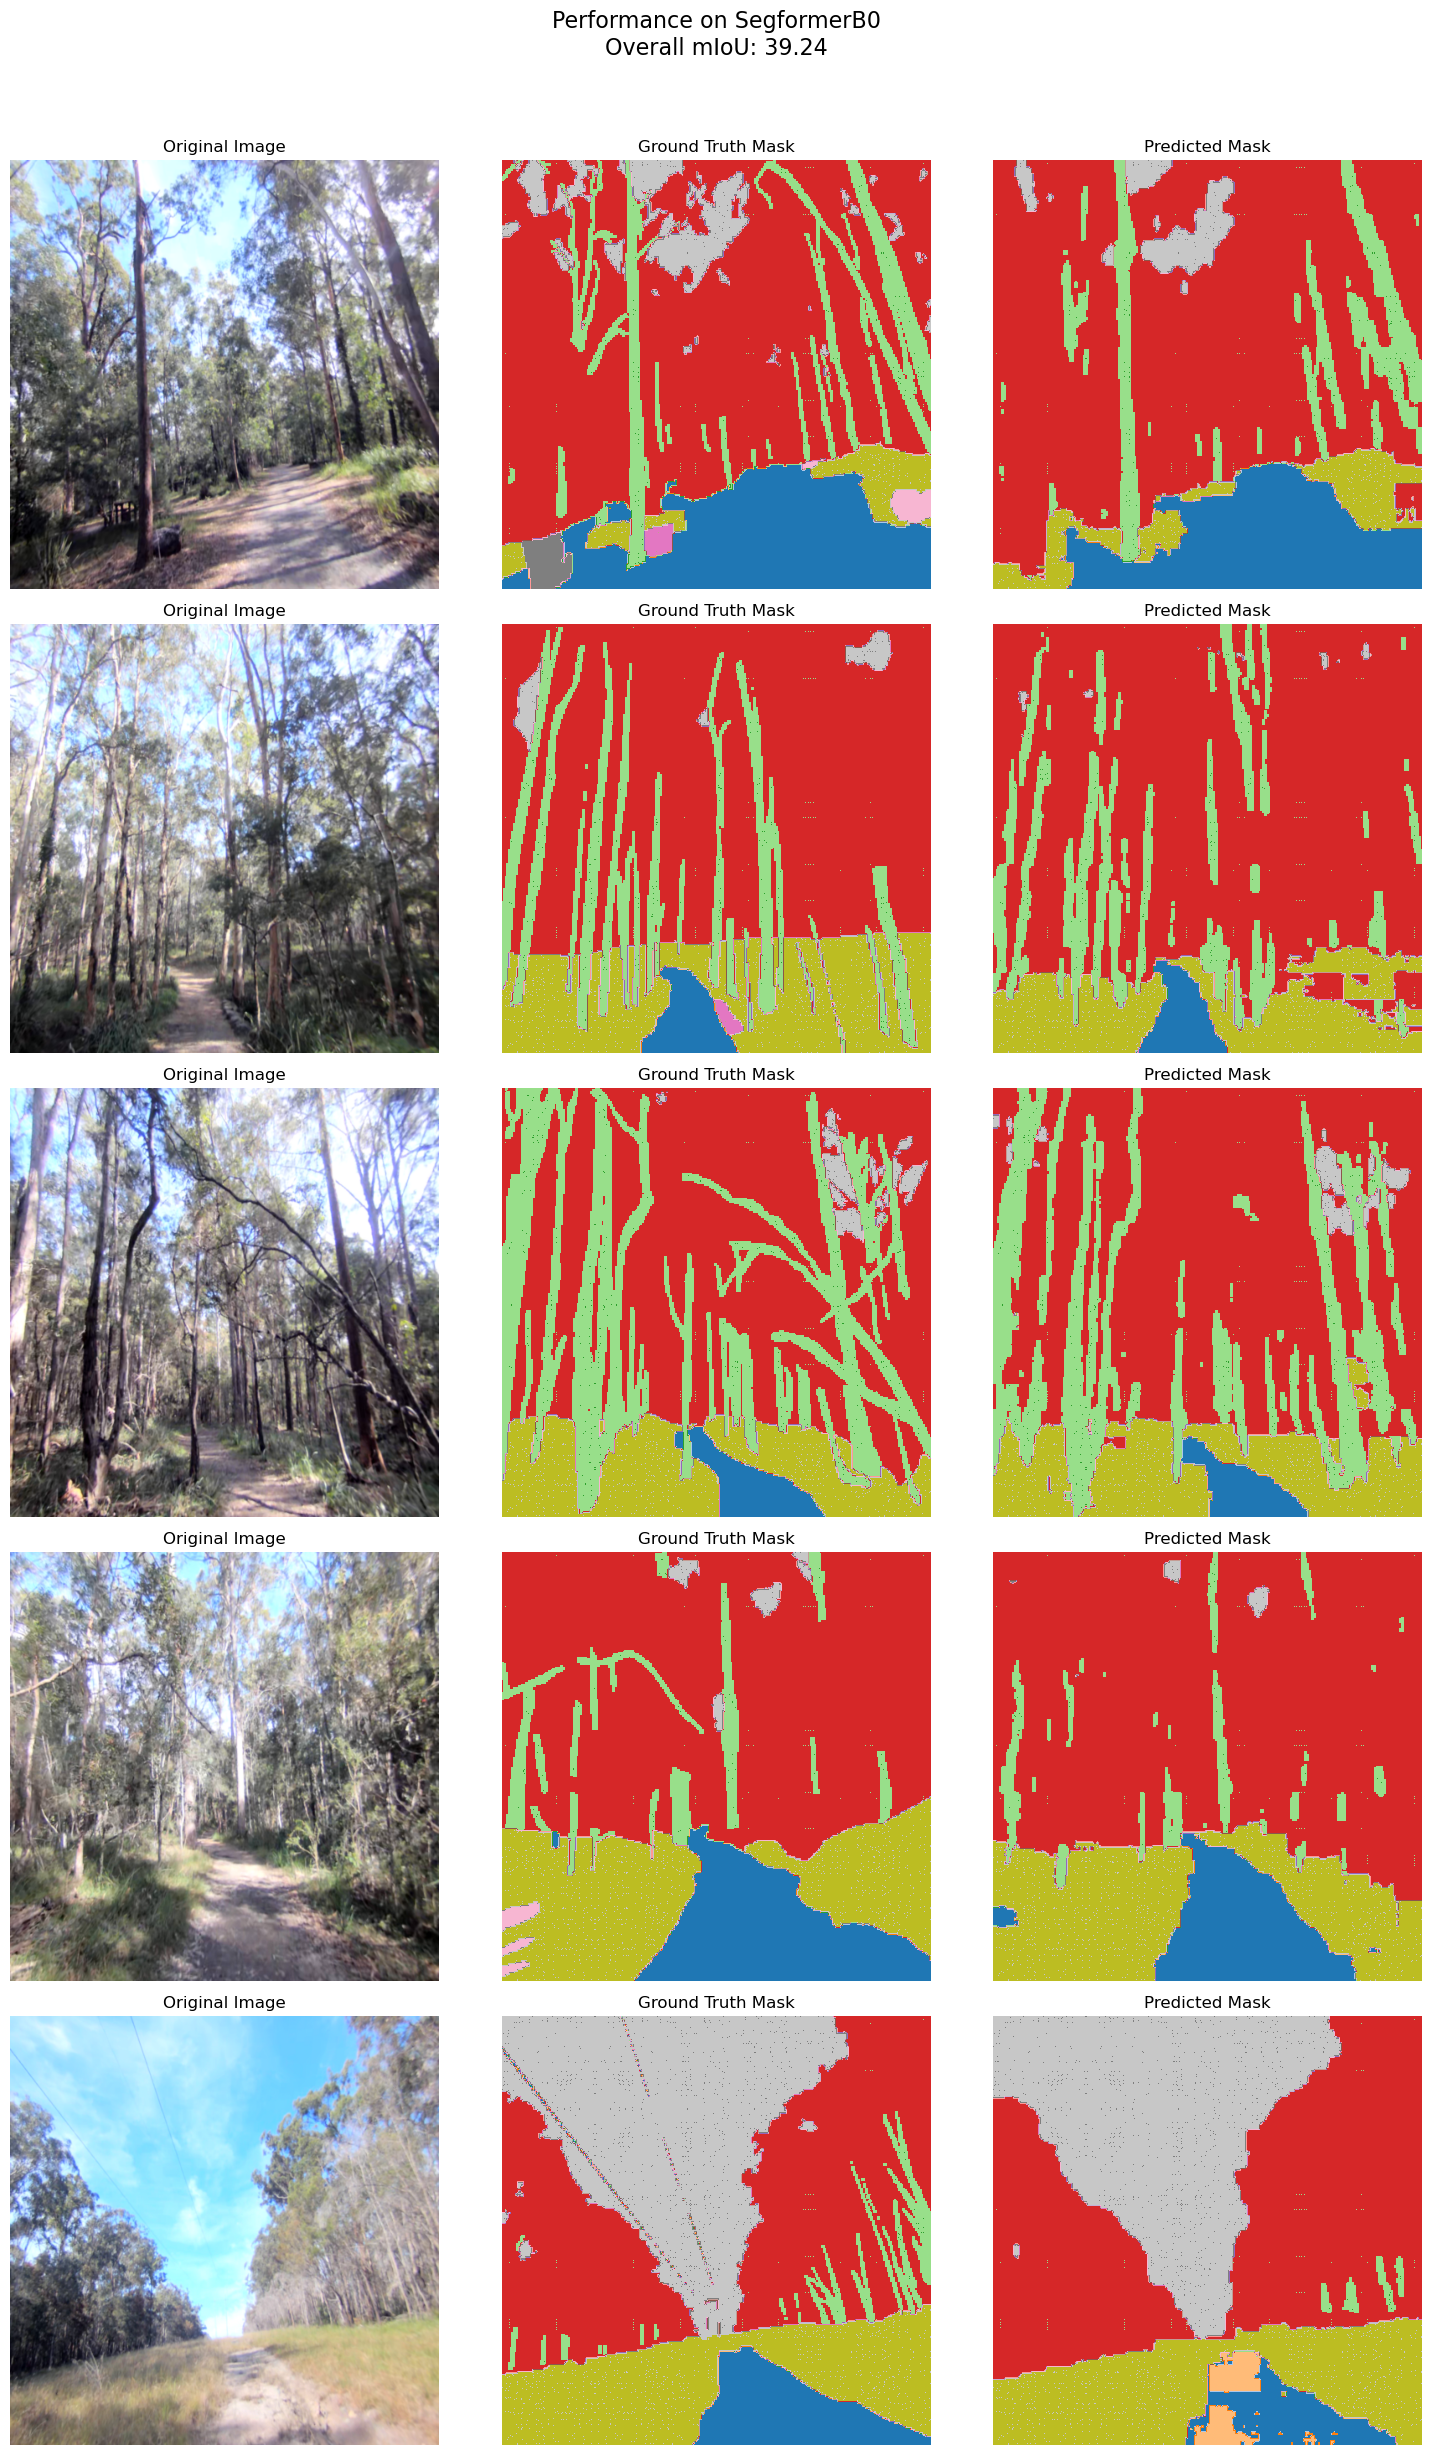

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_predictions(segformer_model, test_loader, device, num_examples=5, num_classes=21,title='SegformerB0')

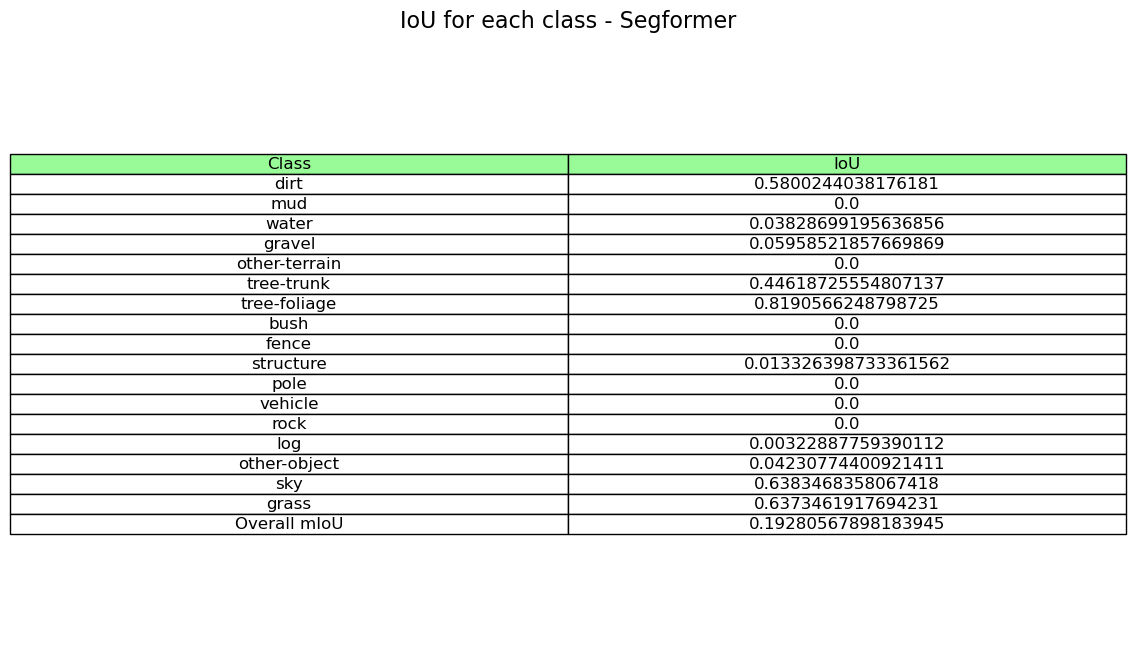

In [35]:


# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_labels = METAINFO["classes"]
num_classes = len(class_labels)

# Assuming you have a test_loader and a trained model
class_ious = evaluate_model_performance(segformer_model, test_loader, device, num_classes=num_classes)
plot_iou_table(class_ious, class_labels, method_name='Segformer')


In [36]:
#Free the GPU Memory
import torch
import gc
del segformer_criterion
del segformer_model
del segformer_optimizer
gc.collect()
# free memory
torch.cuda.empty_cache()
